In [2]:
import subprocess
import os

import pandas as pd
import numpy as np
import requests

from datetime import datetime

from bs4 import BeautifulSoup


%matplotlib inline


import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objects as go


In [3]:
mpl.rcParams['figure.figsize'] = [16, 9]
pd.set_option('display.max_rows', 500)

sns.set(style="darkgrid")

![CRISP_DM](../reports/figures/CRISP_DM.png)

# DATA LOAD

In [14]:
df_analyse=pd.read_csv('../data/processed/COVID_small_sync_timeline_table.csv',sep=';',parse_dates=[0])
df_analyse.sort_values('date',ascending=True).head()

,doubling every day,doubling every two days,doubling every 4 days,doubling every 10 days,Italy,US,Spain,Germany,China,date
0,100.0,100.000000,100.000000,100.000000,155.0,104.0,120.0,130.0,548.0,0
1,200.0,141.421356,118.920712,107.177346,229.0,174.0,165.0,159.0,643.0,1
2,400.0,200.000000,141.421356,114.869835,322.0,222.0,222.0,196.0,920.0,2
3,800.0,282.842712,168.179283,123.114441,453.0,337.0,259.0,262.0,1406.0,3
4,1600.0,400.000000,200.000000,131.950791,655.0,451.0,400.0,482.0,2075.0,4


In [23]:
country_list=df_analyse.columns[1:]

In [27]:
country_list

Index(['doubling every two days', 'doubling every 4 days',
       'doubling every 10 days', 'Italy', 'US', 'Spain', 'Germany', 'China',
       'date'],
      dtype='object')

# Helper function

In [25]:
def quick_plot(x_in, df_input,y_scale='log',slider=False):
    """ Quick basic plot for quick static evaluation of a time series
    
        you can push selective columns of your data frame by .iloc[:,[0,6,7,8]]
        
        Parameters:
        ----------
        x_in : array 
            array of date time object, or array of numbers
        df_input : pandas dataframe 
            the plotting matrix where each column is plotted
            the name of the column will be used for the legend
        scale: str
            y-axis scale as 'log' or 'linear'
        slider: bool
            True or False for x-axis slider
    
        
        Returns:
        ----------
        
    """
    fig = go.Figure()

    for each in df_input.columns:
        fig.add_trace(go.Scatter(
                        x=x_in,
                        y=df_input[each],
                        name=each,
                        opacity=0.8))
    
    fig.update_layout(autosize=True,
        width=1024,
        height=768,
        font=dict(
            family="PT Sans, monospace",
            size=18,
            color="#7f7f7f"
            )
        )
    fig.update_yaxes(type=y_scale),
    fig.update_xaxes(tickangle=-45,
                 nticks=20,
                 tickfont=dict(size=14,color="#7f7f7f")
                )
    if slider==True:
        fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()
      
    

In [28]:
quick_plot(df_analyse.date,
           df_analyse.iloc[:,3:-1],
           y_scale='log',
           slider=True)

# Fitting a polynomial curve 

In [66]:
df_poly_check=df_analyse.iloc[0:27,3:-1].reset_index()
df_poly_check.head()

,index,doubling every 10 days,Italy,US,Spain,Germany,China
0,0,100.000000,155.0,104.0,120.0,130.0,548.0
1,1,107.177346,229.0,174.0,165.0,159.0,643.0
2,2,114.869835,322.0,222.0,222.0,196.0,920.0
3,3,123.114441,453.0,337.0,259.0,262.0,1406.0
4,4,131.950791,655.0,451.0,400.0,482.0,2075.0


In [67]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [68]:
y=df_poly_check[['Germany','Italy','US','Spain']].unstack().sort_index(axis=0,level=1)

In [69]:
y.head()

Germany  0    130.0
Italy    0    155.0
US       0    104.0
Spain    0    120.0
Germany  1    159.0
dtype: float64

In [70]:
test_points=28
y_train=y[0:-test_points-1]
y_test=y[-test_points:]

In [71]:
X_train=np.arange(len(y_train)).reshape(-1, 1)/4.0 
X_test=np.arange(len(y_train),len(y_train)+test_points).reshape(-1, 1)/4.0

In [75]:
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn;
seaborn.set(rc={'figure.figsize':(16,8)})
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

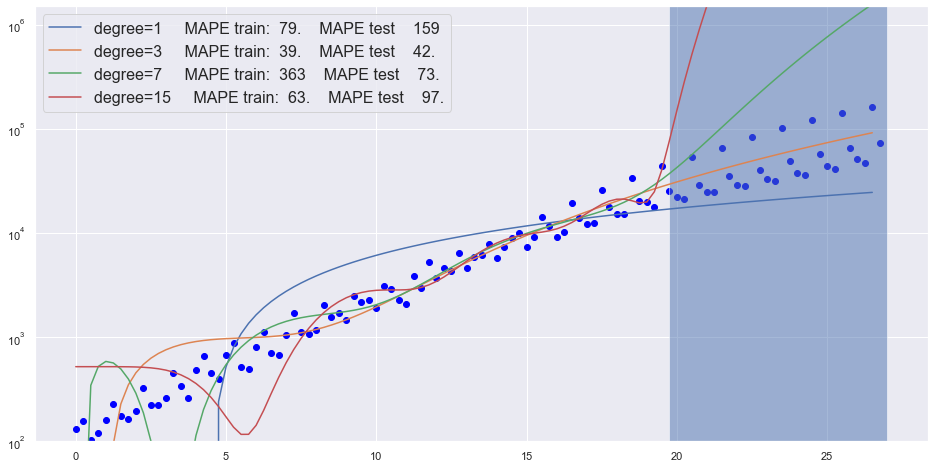

In [76]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(np.arange(len(y))/4,y, color='blue')
ax1.axvspan((len(y)-test_points-1)/4, len(y)/4, facecolor='b', alpha=0.5)

for degree in [1,3,7,15]:
    y_hat_insaple=PolynomialRegression(degree).fit(X_train, y_train).predict(X_train)
    y_hat_test = PolynomialRegression(degree).fit(X_train, y_train).predict(X_test)



    X_plot=np.concatenate((X_train, X_test), axis=None)
    y_plot=np.concatenate((y_hat_insaple, y_hat_test), axis=None)

    ax1.plot(X_plot, y_plot, label='degree={0}'.format(degree)+ 
                 '     MAPE train:  ' + str(mean_absolute_percentage_error(y_hat_insaple, y_train))[0:3]
                 +'    MAPE test    ' + str(mean_absolute_percentage_error(y_hat_test, y_test))[0:3])

ax1.set_ylim(100, 1500000)
ax1.set_yscale('log')
ax1.legend(loc='best',
           prop={'size': 16});